In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [3]:
# preprocess dataframe - duration and month
pre_df["arrivalDate"] = pd.to_datetime(pre_df["arrivalDate"])
pre_df["sailingDate"] = pd.to_datetime(pre_df["sailingDate"])
pre_df["duration"] = pd.to_datetime(pre_df["sailingDate"]) - pd.to_datetime(pre_df["arrivalDate"])
pre_df["month"] = pre_df["arrivalDate"].dt.month

In [4]:
# preprocess dataframe - vessel type
from sklearn.preprocessing import LabelEncoder

display(pre_df["vessel.vesselType"].unique())
le_type = LabelEncoder()
pre_df["vessel.vesselType"] = le_type.fit_transform(pre_df["vessel.vesselType"])

array(['crude oil tanker', 'product tanker',
       'fully cellular containership', 'vehicle carrier',
       'Combined chemical and oil tanker', 'chemical tanker',
       'Liquefied Petroleum Gas Carrier', 'semi-sub HL vessel',
       'bulk carrier', 'general cargo with container capacity', 'tug',
       'passenger (cruise)', 'patrol ship', 'Tanker (unspecified)',
       'asphalt tanker', 'tug/supply', 'general cargo',
       'Vessel Type (unspecified)', 'Roll On Roll Off'], dtype=object)

In [5]:
# preprocess data
# sort by imo number
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_unlocode'] = pre_df.groupby('IMO')['place.unlocode'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
df_cleaned = pre_df[~pre_df["is_last_imo"]]

In [6]:
# encode unlocode, next unlocode
le_unlocode = LabelEncoder()
all_unlocodes = pd.concat([pre_df["place.unlocode"], pre_df["next_unlocode"]])
le_unlocode.fit(all_unlocodes)
pre_df["place.unlocode"] = le_unlocode.transform(pre_df["place.unlocode"])
pre_df["next_unlocode"] = le_unlocode.transform(pre_df["next_unlocode"])

In [7]:
# drop all the rows containing Arrival, as this causes a "self" directed nodes
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

In [8]:
pre_df['duration'] = pre_df['duration'] / pd.Timedelta(days=1)

In [9]:
# cap duration - outliers
cap = pre_df['duration'].quantile(.95)
pre_df['capped_duration'] = pre_df['duration'].apply(lambda x: min(x, cap))

In [10]:
# data statistics
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172213 entries, 314761 to 12579
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   arrivalDate        172213 non-null  datetime64[ns]
 1   sailingDate        172213 non-null  datetime64[ns]
 2   place.placeName    172213 non-null  object        
 3   place.unlocode     172213 non-null  int32         
 4   place.placeType    172213 non-null  object        
 5   place.countryName  172213 non-null  object        
 6   Timestamp          172213 non-null  object        
 7   Event_Type         172213 non-null  object        
 8   IMO                172213 non-null  int64         
 9   vessel.vesselName  172213 non-null  object        
 10  vessel.vesselType  172213 non-null  int32         
 11  duration           172213 non-null  float64       
 12  month              172213 non-null  int32         
 13  next_unlocode      172213 non-null  int32    

In [11]:
pre_df.describe().T

,count,mean,min,25%,50%,75%,max,std
arrivalDate,172213,2022-06-01 20:06:27.902451968,2021-01-01 00:01:47,2021-09-11 20:03:07,2022-06-15 17:00:12,2023-02-20 02:52:42,2023-09-30 23:59:49,NaN
sailingDate,172213,2022-06-03 09:35:48.758241536,2021-01-01 02:30:01,2021-09-13 15:50:12,2022-06-17 06:26:56,2023-02-21 13:06:51,2023-10-09 10:42:12,NaN
place.unlocode,172213.0,945.150616,0.0,382.0,1010.0,1452.0,1778.0,523.039656
IMO,172213.0,9482489.166486,1026764.0,9326744.0,9443865.0,9661235.0,9951135.0,249425.244169
vessel.vesselType,172213.0,10.574376,0.0,9.0,9.0,14.0,18.0,5.083378
duration,172213.0,1.562047,0.0,0.587674,1.022176,1.724363,283.931273,2.903167
month,172213.0,6.081782,1.0,3.0,6.0,9.0,12.0,3.264448
next_unlocode,172213.0,952.013234,0.0,382.0,1010.0,1452.0,1779.0,526.397807
capped_duration,172213.0,1.329843,0.0,0.587674,1.022176,1.724363,4.106442,1.013789


In [12]:
pre_df = pre_df.rename(columns={'place.unlocode':'unlocode', 'vessel.vesselType':'vesselType'})
df = pre_df[["unlocode", "month", "capped_duration", "vesselType", "next_unlocode"]]

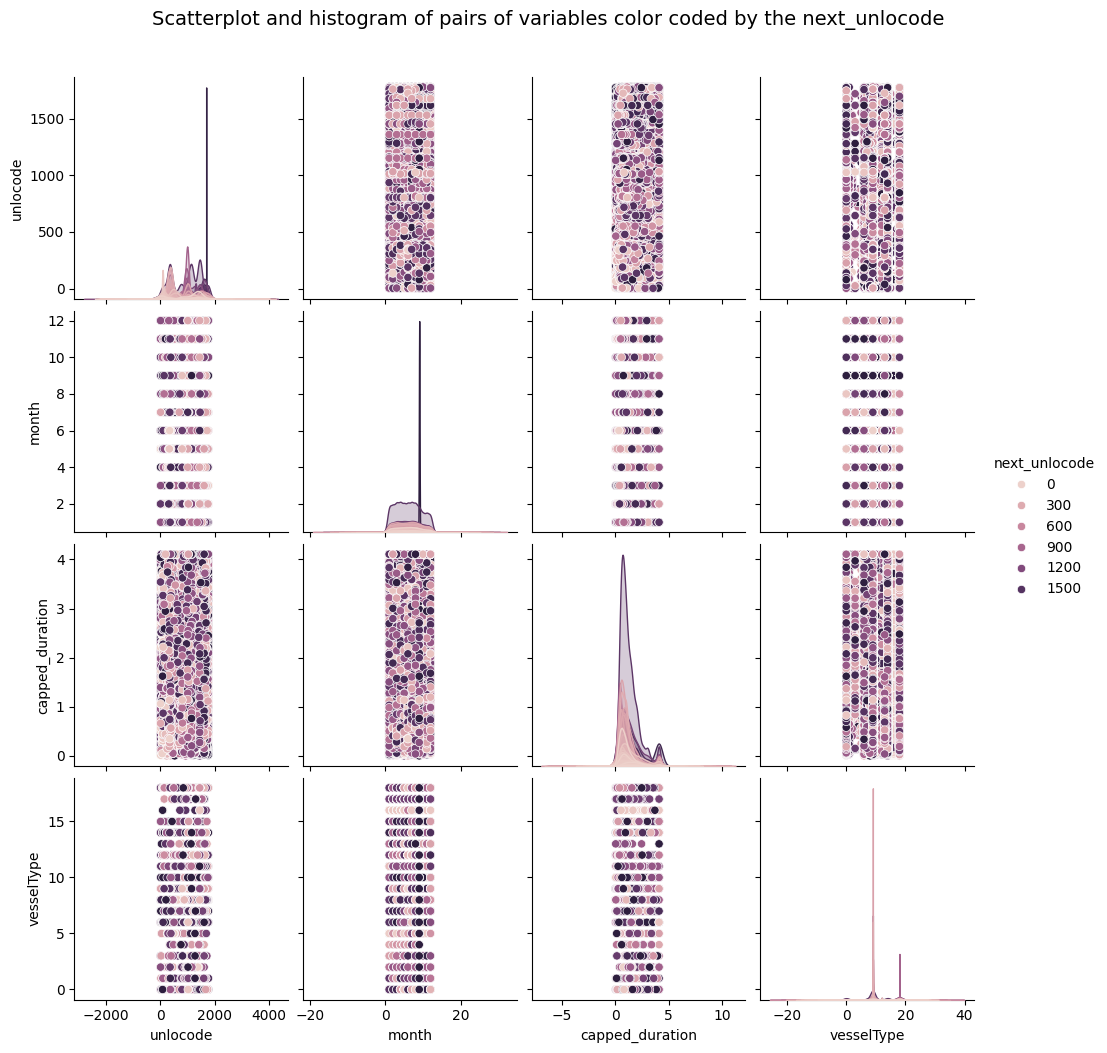

In [13]:
g = sns.pairplot(df, hue='next_unlocode')
g.figure.suptitle("Scatterplot and histogram of pairs of variables color coded by the next_unlocode", 
               fontsize = 14,
               y=1.05);

In [14]:
df['capped_duration'] = df['capped_duration'].astype('float32')

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_8780\973350990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capped_duration'] = df['capped_duration'].astype('float32')


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172213 entries, 314761 to 12579
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   unlocode         172213 non-null  int32  
 1   month            172213 non-null  int32  
 2   capped_duration  172213 non-null  float32
 3   vesselType       172213 non-null  int32  
 4   next_unlocode    172213 non-null  int32  
dtypes: float32(1), int32(4)
memory usage: 4.6 MB


In [16]:
# Create X data set and Y data set, then split in test and train
from sklearn.model_selection import train_test_split

y = df['next_unlocode']
X = df.drop(['next_unlocode'], axis=1)

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.7, 
                                                    random_state=SEED)

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


selector = SelectKBest(f_classif, k=4)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)
 
model = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, random_state=SEED)

model.fit(X_train_reduced, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=50, random_state=42)

In [18]:
from sklearn.model_selection import cross_val_score
 
scores = cross_val_score(model, X_train_reduced, y_train, cv=5)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

c:\Users\SyeAli\cs_projects\ais_port_prediction\ais_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average cross-validation score: 0.22


In [19]:
# check Important features
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

# Display
feature_importances_df

,feature,importance
0,unlocode,0.424623
2,capped_duration,0.340502
1,month,0.170496
3,vesselType,0.064379


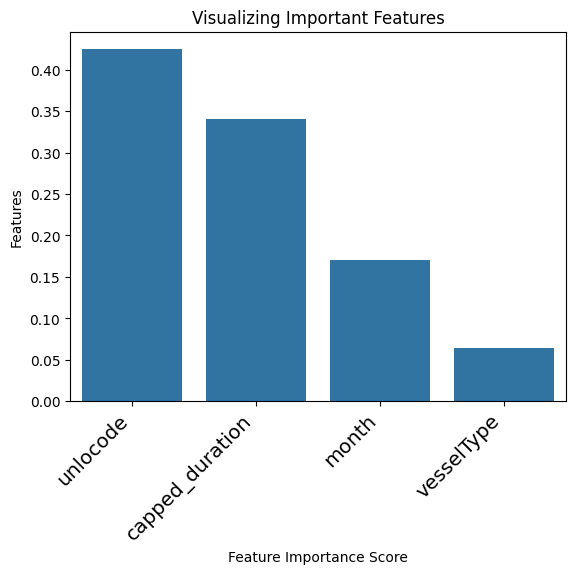

In [20]:
# Creating a bar plot
sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)
# Add labels to your

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()